In [17]:
# health_monitoring/training/train_autoencoder_torch.ipynb
# PPG-DaLiA 데이터 사용
# PyTorch Autoencoder 학습 파이프라인
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

True
1
NVIDIA GeForce RTX 3060


In [2]:
# 루트 경로
cwd = Path(os.getcwd())
ROOT_DIR = cwd.parent

print("루트 경로:", ROOT_DIR)

# 데이터 로드
data_path = ROOT_DIR / "training" / "all_windows.npy"
windows = np.load(data_path)

루트 경로: c:\Users\minsu\i-room-ai\health_monitoring


In [3]:
# Normalize 0~1
windows = (windows - windows.min()) / (windows.max() - windows.min())
windows = windows.astype(np.float32)

# Torch tensor
data_tensor = torch.tensor(windows)
dataset = TensorDataset(data_tensor)

In [4]:
# Train/val split
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [13]:
# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out
    
model = Autoencoder(input_dim=30).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
# 학습
epochs = 30
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item() * batch.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.6f}, Val: {val_loss:.6f}")

Epoch 1/30 - Train: 0.010031, Val: 0.001042
Epoch 2/30 - Train: 0.000700, Val: 0.000584
Epoch 3/30 - Train: 0.000572, Val: 0.000570
Epoch 4/30 - Train: 0.000534, Val: 0.000488
Epoch 5/30 - Train: 0.000438, Val: 0.000419
Epoch 6/30 - Train: 0.000400, Val: 0.000393
Epoch 7/30 - Train: 0.000373, Val: 0.000361
Epoch 8/30 - Train: 0.000337, Val: 0.000347
Epoch 9/30 - Train: 0.000315, Val: 0.000313
Epoch 10/30 - Train: 0.000299, Val: 0.000291
Epoch 11/30 - Train: 0.000277, Val: 0.000266
Epoch 12/30 - Train: 0.000257, Val: 0.000249
Epoch 13/30 - Train: 0.000245, Val: 0.000240
Epoch 14/30 - Train: 0.000238, Val: 0.000241
Epoch 15/30 - Train: 0.000233, Val: 0.000231
Epoch 16/30 - Train: 0.000230, Val: 0.000229
Epoch 17/30 - Train: 0.000228, Val: 0.000228
Epoch 18/30 - Train: 0.000227, Val: 0.000227
Epoch 19/30 - Train: 0.000227, Val: 0.000230
Epoch 20/30 - Train: 0.000226, Val: 0.000228
Epoch 21/30 - Train: 0.000226, Val: 0.000228
Epoch 22/30 - Train: 0.000226, Val: 0.000228
Epoch 23/30 - Train

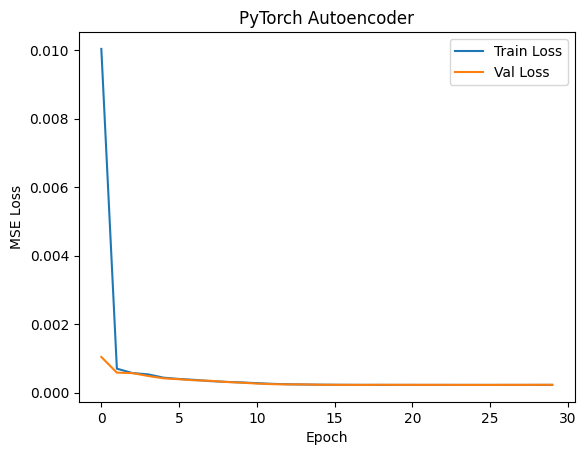

In [15]:
# 학습 곡선
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('PyTorch Autoencoder')
plt.show()

In [16]:
# 모델 & Threshold 저장
model_path = ROOT_DIR / "app" / "models" / "autoencoder_model.pt"
torch.save(model.state_dict(), model_path)
print("모델 저장 완료:", model_path)

# Reconstruction error (Val set)
model.eval()
recon_errors = []
with torch.no_grad():
    for (batch,) in val_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = torch.mean((batch - output) ** 2, dim=1)
        recon_errors.extend(loss.cpu().numpy())

recon_errors = np.array(recon_errors)
threshold = recon_errors.mean() + 3 * recon_errors.std()
np.save(ROOT_DIR / "app" / "models" / "threshold.npy", threshold)
print("Threshold:", threshold)

모델 저장 완료: c:\Users\minsu\i-room-ai\health_monitoring\app\models\autoencoder_model.pt
Threshold: 0.0010473036
